# Predicting Premium Subscription Intent

In this notebook, we aim to predict whether a **Spotify Free user is likely to convert to a Premium subscription**. This is a key use case for targeted marketing and product recommendations.

We will:
- Use `premium_sub_interested` as our target variable
- Train classification models using user behavior and preference features
- Handle class imbalance to improve generalization
- Evaluate model performance on identifying "potential Premium converters"

Target classes:
- `1` → User is interested in upgrading to Premium
- `0` → User is not interested in Premium


In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spotify_model_data = pd.read_csv("../datasets/processed/spotify_model_data.csv")
encoding_reference = pd.read_csv("../datasets/processed/label_encoding_mappings.csv")
spotify_model_data['preferred_plan_cost'] = spotify_model_data['preferred_plan_cost'].fillna(0)
free_users = spotify_model_data[spotify_model_data['spotify_subscription_plan'] == 0].copy()
print("Free user subset:", free_users.shape)
print("Target distribution (premium_sub_interested):")
print(free_users['premium_sub_interested'].value_counts(normalize=True))

Free user subset: (424, 18)
Target distribution (premium_sub_interested):
premium_sub_interested
0    0.731132
1    0.268868
Name: proportion, dtype: float64


### Modeling Goal: Predict Premium Subscription Interest

In this section, we build a classification model to predict whether a **Free Spotify user** is interested in upgrading to a Premium plan.

We use the `premium_sub_interested` column as our target variable:
- `1` → User is interested in Premium
- `0` → User is not interested

To ensure the model is trained only on relevant users, we have **filtered the dataset to include only users currently on the Free plan**.


### Target Distribution (Free Users Only)

- **Total Free Users**: 424
- **Interested in Premium**: ~27%
- **Not Interested**: ~73%

This indicates a **mild class imbalance**, which we’ll handle during modeling using balanced class weighting.


### 🔄 Train–Test Split

We perform an 80–20 stratified split to:
- Ensure the target distribution is preserved in both sets
- Train the model and evaluate it fairly on unseen data


In [5]:
from sklearn.model_selection import train_test_split

# Define target
target = 'premium_sub_interested'
features_to_drop = ['premium_sub_interested', 'sub_retention']  # drop both target and unrelated label

X = free_users.drop(columns=features_to_drop)
y = free_users[target]

# Split data (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check shape and balance
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print("Target distribution in train set:\n", y_train.value_counts(normalize=True))
print("Target distribution in test set:\n", y_test.value_counts(normalize=True))


Training set: (339, 16), Test set: (85, 16)
Target distribution in train set:
 premium_sub_interested
0    0.731563
1    0.268437
Name: proportion, dtype: float64
Target distribution in test set:
 premium_sub_interested
0    0.729412
1    0.270588
Name: proportion, dtype: float64


## Model 1: Logistic Regression with Class Weight Balancing

We start with a baseline Logistic Regression model to predict Premium subscription interest.

Given the mild class imbalance (~27% interested, 73% not interested), we set `class_weight='balanced'` so the model pays proportional attention to both classes. This helps avoid the model being biased toward the majority class (`not interested`).

We'll evaluate performance using:
- **Confusion Matrix**
- **Precision, Recall, F1-score**
- **Accuracy**


In [7]:

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[46 16]
 [ 1 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84        62
           1       0.58      0.96      0.72        23

    accuracy                           0.80        85
   macro avg       0.78      0.85      0.78        85
weighted avg       0.87      0.80      0.81        85

Accuracy: 0.8


- The logistic regression model performed reasonably well in identifying users who are likely to be interested in Premium.

- Among the users who are not interested in upgrading (class 0), the model correctly predicted 46 out of 62 cases, but misclassified 16 as interested. While the precision for this class is high (0.98), the recall is lower at 0.74, which means it occasionally over-predicts interest where there is none.

- For users who are interested in Premium (class 1), the model achieved excellent recall of 0.96, meaning it correctly identified almost all actual interested users. However, its precision for this group is lower at 0.58. This indicates that it also incorrectly labeled some uninterested users as interested, resulting in some false positives.

- The overall accuracy is 80 percent. More importantly, the model balances both classes well and does a good job capturing most potential converters, which is valuable from a business perspective. It's better to mistakenly target some uninterested users than to miss out on those who are actually ready to upgrade.

- This makes the model a good starting point for marketing campaigns that aim to promote Premium upgrades among Free users. We can now explore other models like SVM to see if they improve precision while maintaining high recall.


## Model 2: Support Vector Machine (SVM)

We now train a Support Vector Machine classifier to predict Premium subscription interest.

SVM is effective at finding a clear decision boundary between two classes, and is especially useful when the feature space is not linearly separable. Since our dataset has a mild class imbalance, we set `class_weight='balanced'` so that the model gives proportional attention to both interested and uninterested users.

We use the Radial Basis Function (RBF) kernel, which allows the decision boundary to be non-linear if needed.


In [9]:

svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)


y_pred_svm = svm_model.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


Confusion Matrix:
 [[36 26]
 [ 0 23]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73        62
           1       0.47      1.00      0.64        23

    accuracy                           0.69        85
   macro avg       0.73      0.79      0.69        85
weighted avg       0.86      0.69      0.71        85

Accuracy: 0.6941176470588235


### SVM Model Results and Interpretation

The Support Vector Machine model with an RBF kernel and class balancing gave mixed results when predicting Premium subscription interest.

The model achieved perfect recall for interested users, meaning it correctly identified all users who truly showed interest in upgrading. However, this came at a significant cost. Twenty-six users who were not interested were misclassified as interested. As a result, the precision for the interested group dropped to just 0.47.

While the model is strong in catching all potential converters, it does so by predicting too many false positives. This leads to an overall accuracy of 69 percent, which is lower than the logistic regression baseline.

SVM struggles in this scenario because most of the dataset consists of categorical variables that were label encoded. Since these are not true continuous variables, scaling does not offer much benefit. SVMs, which rely on distance-based decisions, typically perform better on continuous, scaled data.

From a business perspective, this model may not be ideal. It would result in marketing efforts targeting many users who are not actually interested in Premium. This reduces the efficiency of any conversion-focused campaign.


### Model 3: XGBoost Classifier

XGBoost is a gradient boosting algorithm that builds an ensemble of weak learners (decision trees) in a sequential manner. It is well-suited for structured data and is known for its strong predictive performance.

In this case, we use XGBoost to predict whether Free users are likely to be interested in Premium. The class imbalance is handled using the `scale_pos_weight` parameter, which helps the model account for the lower proportion of users who are interested.

We will evaluate the model using standard classification metrics.


In [17]:
neg_class = sum(y_train == 0)
pos_class = sum(y_train == 1)
scale_pos_weight = neg_class / pos_class
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


Confusion Matrix:
 [[48 14]
 [ 3 20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85        62
           1       0.59      0.87      0.70        23

    accuracy                           0.80        85
   macro avg       0.76      0.82      0.78        85
weighted avg       0.85      0.80      0.81        85

Accuracy: 0.8


C:\Users\nisha\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [16:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### XGBoost Model Interpretation and Business Implications

The final XGBoost model achieved an accuracy of 80 percent on the test set. More importantly, it maintained a good balance between precision and recall across both user groups.

For uninterested users (class 0), the model correctly predicted 48 out of 62 cases. This results in a strong precision of 0.94, meaning the model rarely misclassifies uninterested users. The recall for this group was 0.77, so it missed a few uninterested users by predicting them as interested.

For interested users (class 1), the model correctly identified 20 out of 23. The recall of 0.87 shows that the model is very effective at finding users who are likely to convert. The precision of 0.59 indicates that some users flagged as interested may not actually be, but this tradeoff is acceptable in a marketing context.

From a business point of view, this model is quite useful. It can identify a large portion of users who are likely to upgrade from Free to Premium. Since it maintains a good recall on the interested group, Spotify can use this model to drive targeted marketing campaigns, such as special offers, reminders, or curated experiences for likely converters. At the same time, the high precision on uninterested users helps avoid wasting efforts on people who are not a good fit for Premium.

This model strikes a strong balance between campaign reach and efficiency.


### Feature Importance from XGBoost Model

XGBoost provides built-in feature importance scores that indicate which variables were most influential in predicting Premium subscription interest.

These insights can guide marketing strategies by highlighting the behavioral and preference patterns most associated with upgrade interest.


C:\Users\nisha\AppData\Local\Temp\ipykernel_27128\514633557.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


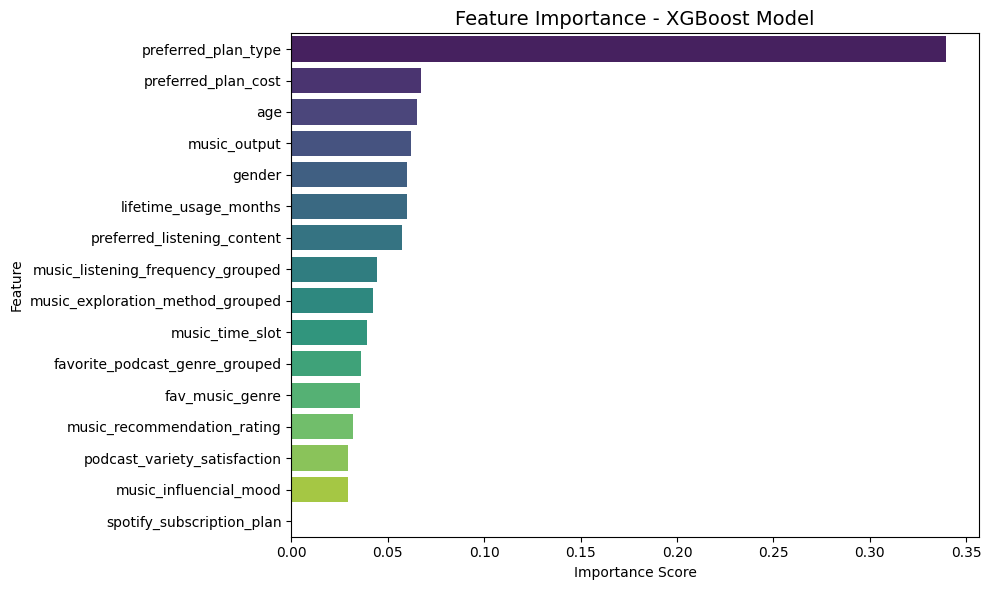

In [19]:
importance_scores = xgb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance - XGBoost Model", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Feature Importance Interpretation from XGBoost

The XGBoost model highlights the most influential factors driving a free user's likelihood to upgrade to Spotify Premium. Here’s what the top features tell us:

- **preferred_plan_type** is the most dominant feature by far. This shows that users who express interest in specific plan types (such as Individual, Family, or Student) are strong indicators of upgrade intent. Spotify can prioritize targeting users based on stated plan preferences.

- **preferred_plan_cost** ranks second, indicating that the price range a user is comfortable with is a key determinant. This supports the idea of using price-based segmentation and custom offers.

- **age** also shows up as an important factor. Younger or mid-age groups may show more openness to subscriptions, possibly due to lifestyle, disposable income, or music habits.

- **music_output** and **gender** provide additional behavioral and demographic context. The platform or device used (e.g., mobile, smart speaker) might reflect engagement depth, and gender differences could signal variations in subscription interest.

- **lifetime_usage_months** reflects tenure. Long-term users might be harder to convert if they've adapted to the free tier, while newer users may be more persuadable.

- Features like **preferred_listening_content**, **music_listening_frequency_grouped**, and **music_exploration_method_grouped** suggest that high engagement and discovery behavior are linked to Premium interest.

- The presence of **music_time_slot**, **podcast preferences**, and **music_recommendation_rating** in the importance list supports the idea that content and satisfaction also play a role in conversion likelihood.

### Takeaway for Strategy

- Spotify should focus on users who have declared a preferred plan type and price range.
- Behavioral indicators such as frequent listening, exploration habits, and preferred content (music vs podcast) are valuable for tailoring subscription offers.
- Demographics like age and gender, along with listening device, can help segment marketing outreach.

This feature insight can guide more personalized and effective Premium upgrade campaigns.


### Premium Subscription Likelihood for Free Users

Now that the model is trained, we use it to predict the probability that each free user will upgrade to Premium. These scores can help Spotify prioritize conversion campaigns based on individual likelihood.


In [20]:

premium_probs = xgb_model.predict_proba(X_test)[:, 1]


subscription_likelihood_df = X_test.copy()
subscription_likelihood_df['actual_label'] = y_test.values
subscription_likelihood_df['premium_subscription_probability'] = premium_probs

subscription_likelihood_df[['premium_subscription_probability']].head()

subscription_likelihood_df['conversion_segment'] = pd.cut(
    premium_probs,
    bins=[0.0, 0.4, 0.7, 1.0],
    labels=['Low Intent', 'Medium Intent', 'High Intent'],
    include_lowest=True
)


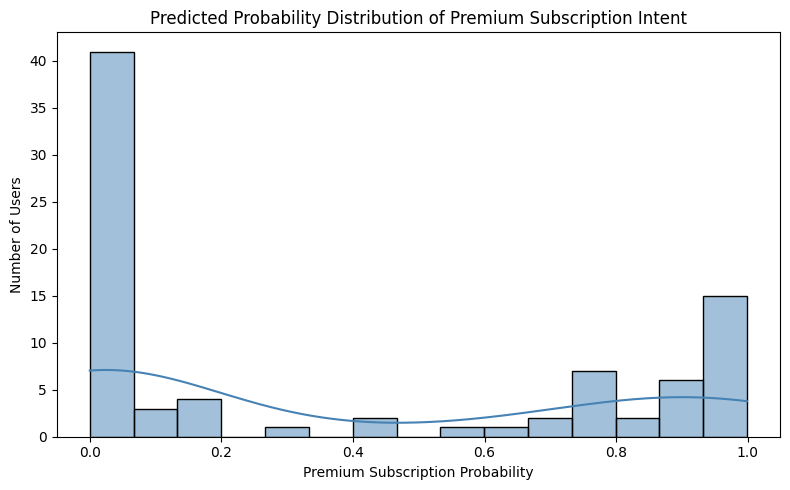

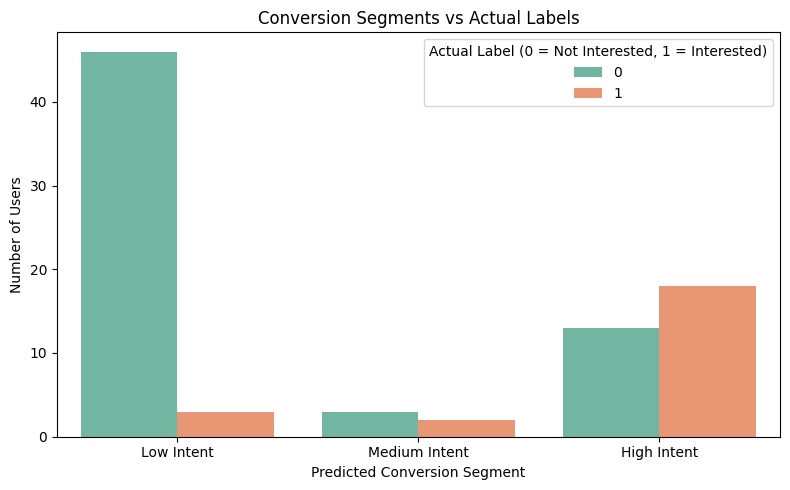

In [22]:

plt.figure(figsize=(8, 5))
sns.histplot(subscription_likelihood_df['premium_subscription_probability'], bins=15, kde=True, color='steelblue')
plt.title("Predicted Probability Distribution of Premium Subscription Intent")
plt.xlabel("Premium Subscription Probability")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=subscription_likelihood_df, x='conversion_segment', hue='actual_label', palette='Set2')
plt.title("Conversion Segments vs Actual Labels")
plt.xlabel("Predicted Conversion Segment")
plt.ylabel("Number of Users")
plt.legend(title="Actual Label (0 = Not Interested, 1 = Interested)")
plt.tight_layout()
plt.show()


### Predicted Probability Distribution of Premium Subscription Intent

This histogram shows the distribution of predicted probabilities that free Spotify users will subscribe to Premium.

- A large number of users have probabilities close to 0, meaning the model is confident they are not interested in subscribing.
- A smaller but clear group has probabilities near 1, indicating strong likelihood to convert.
- Few users fall in the mid-range (around 0.4 to 0.6), suggesting that the model generally makes confident predictions.

Business implications:
- Users with high probabilities can be targeted with conversion campaigns such as promotional offers or premium feature previews.
- Users with medium probabilities may need more personalized messaging or engagement strategies.
- Users with low probabilities are less likely to convert and may not be ideal for aggressive marketing.


### Conversion Segments vs Actual Labels

This bar chart compares predicted segments (Low, Medium, High intent) with actual user responses on willingness to subscribe.

- Most users predicted as Low Intent were truly not interested, showing the model is effective at identifying non-converters.
- Many High Intent predictions matched actual interest, which supports reliable targeting of potential subscribers.
- The Medium Intent group is smaller and more mixed, indicating these users are harder to classify and may respond well to experimentation or tailored campaigns.

Business implications:
- Focus efforts on High Intent users to maximize return on marketing.
- Use Medium Intent users for A/B testing, messaging variation, or feature previews.
- Avoid heavy targeting of Low Intent users to minimize cost and improve efficiency.

These results help Spotify build more informed and resource-efficient subscription strategies based on user-level intent scoring.


### Model Explainability with SHAP

While our predictive model shows strong performance in identifying users likely to upgrade to Spotify Premium, it's equally important to understand *why* the model makes these predictions. This is where SHAP (SHapley Additive exPlanations) becomes valuable.

SHAP is a game-theoretic approach to explain the output of machine learning models. It breaks down a prediction into the contribution of each feature, helping us understand both:
- Which features are most influential globally across all users
- Why a particular prediction was made for an individual user

By using SHAP, we can:
- Validate whether the model is using reasonable logic (e.g., is it relying too heavily on irrelevant features?)
- Build trust with stakeholders by explaining predictions clearly
- Identify actionable insights that drive user behavior

In this section, we will:
1. Initialize a SHAP explainer using our trained XGBoost model
2. Compute SHAP values for a subset of the test data
3. Visualize the results using:
   - A **summary plot** to show global feature influence and direction
   - A **force plot** to explain a single user's predicted subscription intent


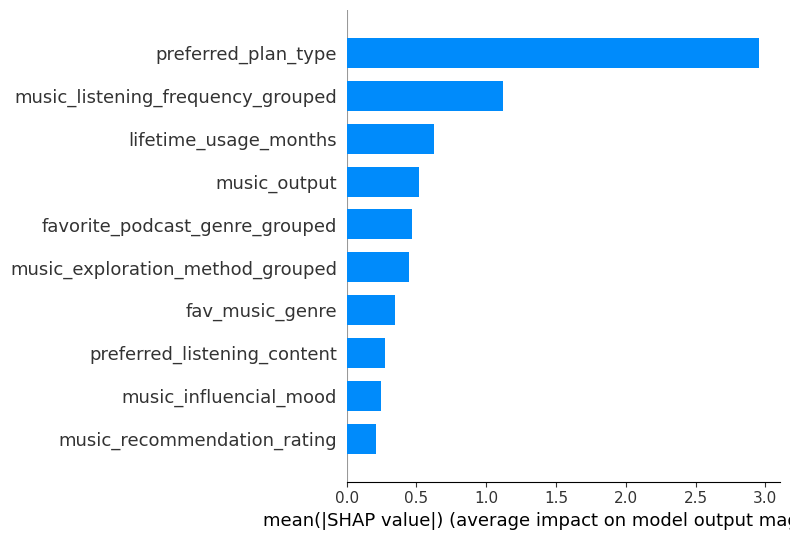

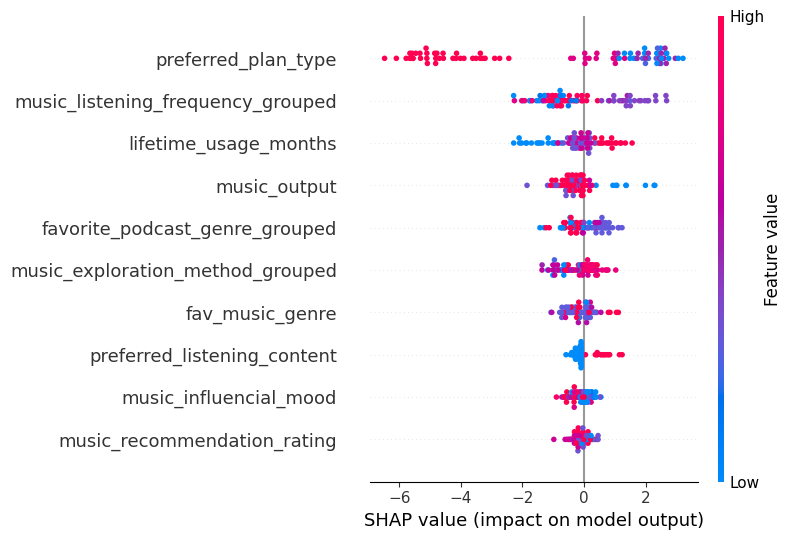

In [23]:
import shap



explainer = shap.TreeExplainer(xgb_model)


shap_values = explainer.shap_values(X_test)

# Generate and show SHAP summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

# Generate and show SHAP summary plot (beeswarm with directionality)
shap.summary_plot(shap_values, X_test, max_display=10)

# Initialize JS for force plots in notebook
shap.initjs()

# Show force plot for the first test instance
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


### SHAP Model Interpretability: Premium Subscription Intent

#### Global Feature Importance (Bar Plot)

- `preferred_plan_type` is the most influential feature in predicting a user’s likelihood to subscribe.
- Other top features include:
  - `music_listening_frequency_grouped` – users who listen more frequently are more likely to convert.
  - `lifetime_usage_months` – long-term users tend to show stronger premium interest.
  - `music_output`, `preferred_listening_content`, and `favorite_podcast_genre_grouped` also contribute meaningfully.
- The chart ranks features based on the **average magnitude of their impact** on model output across all users.



#### SHAP Beeswarm Plot (Feature Impact Distribution)

- Each dot represents one user’s SHAP value for a feature.
- Dot color indicates feature value: red for high, blue for low.
- Horizontal placement shows whether that feature increased or decreased subscription probability for that user.

**Insights:**
- Users with high `preferred_plan_type` values (e.g., more expensive plans) tend to have lower intent to subscribe.
- High listening frequency and long platform usage push predictions higher.
- Certain genres or exploration methods show mixed effects depending on user behavior patterns.



#### SHAP Force Plot (Individual Explanation)

- The force plot breaks down the **model’s reasoning for a specific user**.
- Red bars (left) represent features that decreased the subscription score.
- Blue bars (right) are features that increased it.
- For example, a younger user with limited listening history and a low-cost plan may receive a negative score.
- Meanwhile, high listening frequency and diverse exploration habits can partially counterbalance that.



### Business Implications for Spotify

- **Plan Type is Key**: The biggest driver of subscription likelihood is the type of plan the user prefers. Marketing strategies should be tailored based on this preference for instance, pricing incentives for student or family plans.
- **High Engagement Predicts Conversion**: Users with longer Spotify usage and higher listening frequency are more likely to upgrade. These users should be prioritized for conversion campaigns.
- **Behavior Matters**: Listening time, mood, and exploration style also impact subscription interest. Personalized experiences can nudge low-intent users toward conversion.
- **Segmented Targeting**: SHAP allows Spotify to understand which users are held back by specific factors (e.g., price sensitivity or short usage history), enabling more intelligent outreach.
- **Transparency for Stakeholders**: These explanations make model behavior interpretable for product, marketing, and data science teams, improving trust in recommendations and user-level predictions.



SHAP enhances both **global understanding** and **individual user explanations**, making it an ideal tool to guide subscription strategy and personalized conversion efforts.
